In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
file_path = '/home/guhangsong/Data/heart_disease/heart.csv'
df = pd.read_csv(file_path)

In [3]:
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
val_df = df.sample(frac=0.2, random_state=1337)
train_df = df.drop(val_df.index)

print(f'Using {len(train_df)} samples for training and {len(val_df)} for validation')

Using 242 samples for training and 61 for validation


In [6]:
def df_to_ds(df):
    df = df.copy()
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds

train_ds = df_to_ds(train_df)
val_ds = df_to_ds(val_df)

2022-03-20 19:44:55.776437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-20 19:44:55.809452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-20 19:44:55.809763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-20 19:44:55.810583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [7]:
for x, y in train_ds.take(1):
    print('Input:', x)
    print('Target:', y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=59>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=170>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=326>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=140>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=3.4>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


In [8]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [9]:
from tensorflow.keras.layers import IntegerLookup, Normalization, StringLookup

def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode='binary')

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)

    encoded_feature = lookup(feature)
    return encoded_feature

In [10]:
sex = keras.Input(shape=(1,), name='sex', dtype='int64')
cp = keras.Input(shape=(1,), name='cp', dtype='int64')
fbs = keras.Input(shape=(1,), name='fbs', dtype='int64')
restecg = keras.Input(shape=(1,), name='restecg', dtype='int64')
exang = keras.Input(shape=(1,), name='exang', dtype='int64')
ca = keras.Input(shape=(1,), name='ca', dtype='int64')

thal = keras.Input(shape=(1,), name='thal', dtype='string')

age = keras.Input(shape=(1,), name='age')
trestbps = keras.Input(shape=(1,), name='trestbps')
chol = keras.Input(shape=(1,), name='chol')
thalach = keras.Input(shape=(1,), name='thalach')
oldpeak = keras.Input(shape=(1,), name='oldpeak')
slope = keras.Input(shape=(1,), name='slope')

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca, 
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope
]

sex_encoded = encode_categorical_feature(sex, 'sex', train_ds, False)
cp_encoded = encode_categorical_feature(cp, 'cp', train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

x = layers.Dense(32, activation='relu')(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(all_inputs, output)
model.compile('adam', 'binary_crossentropy', metrics='accuracy')

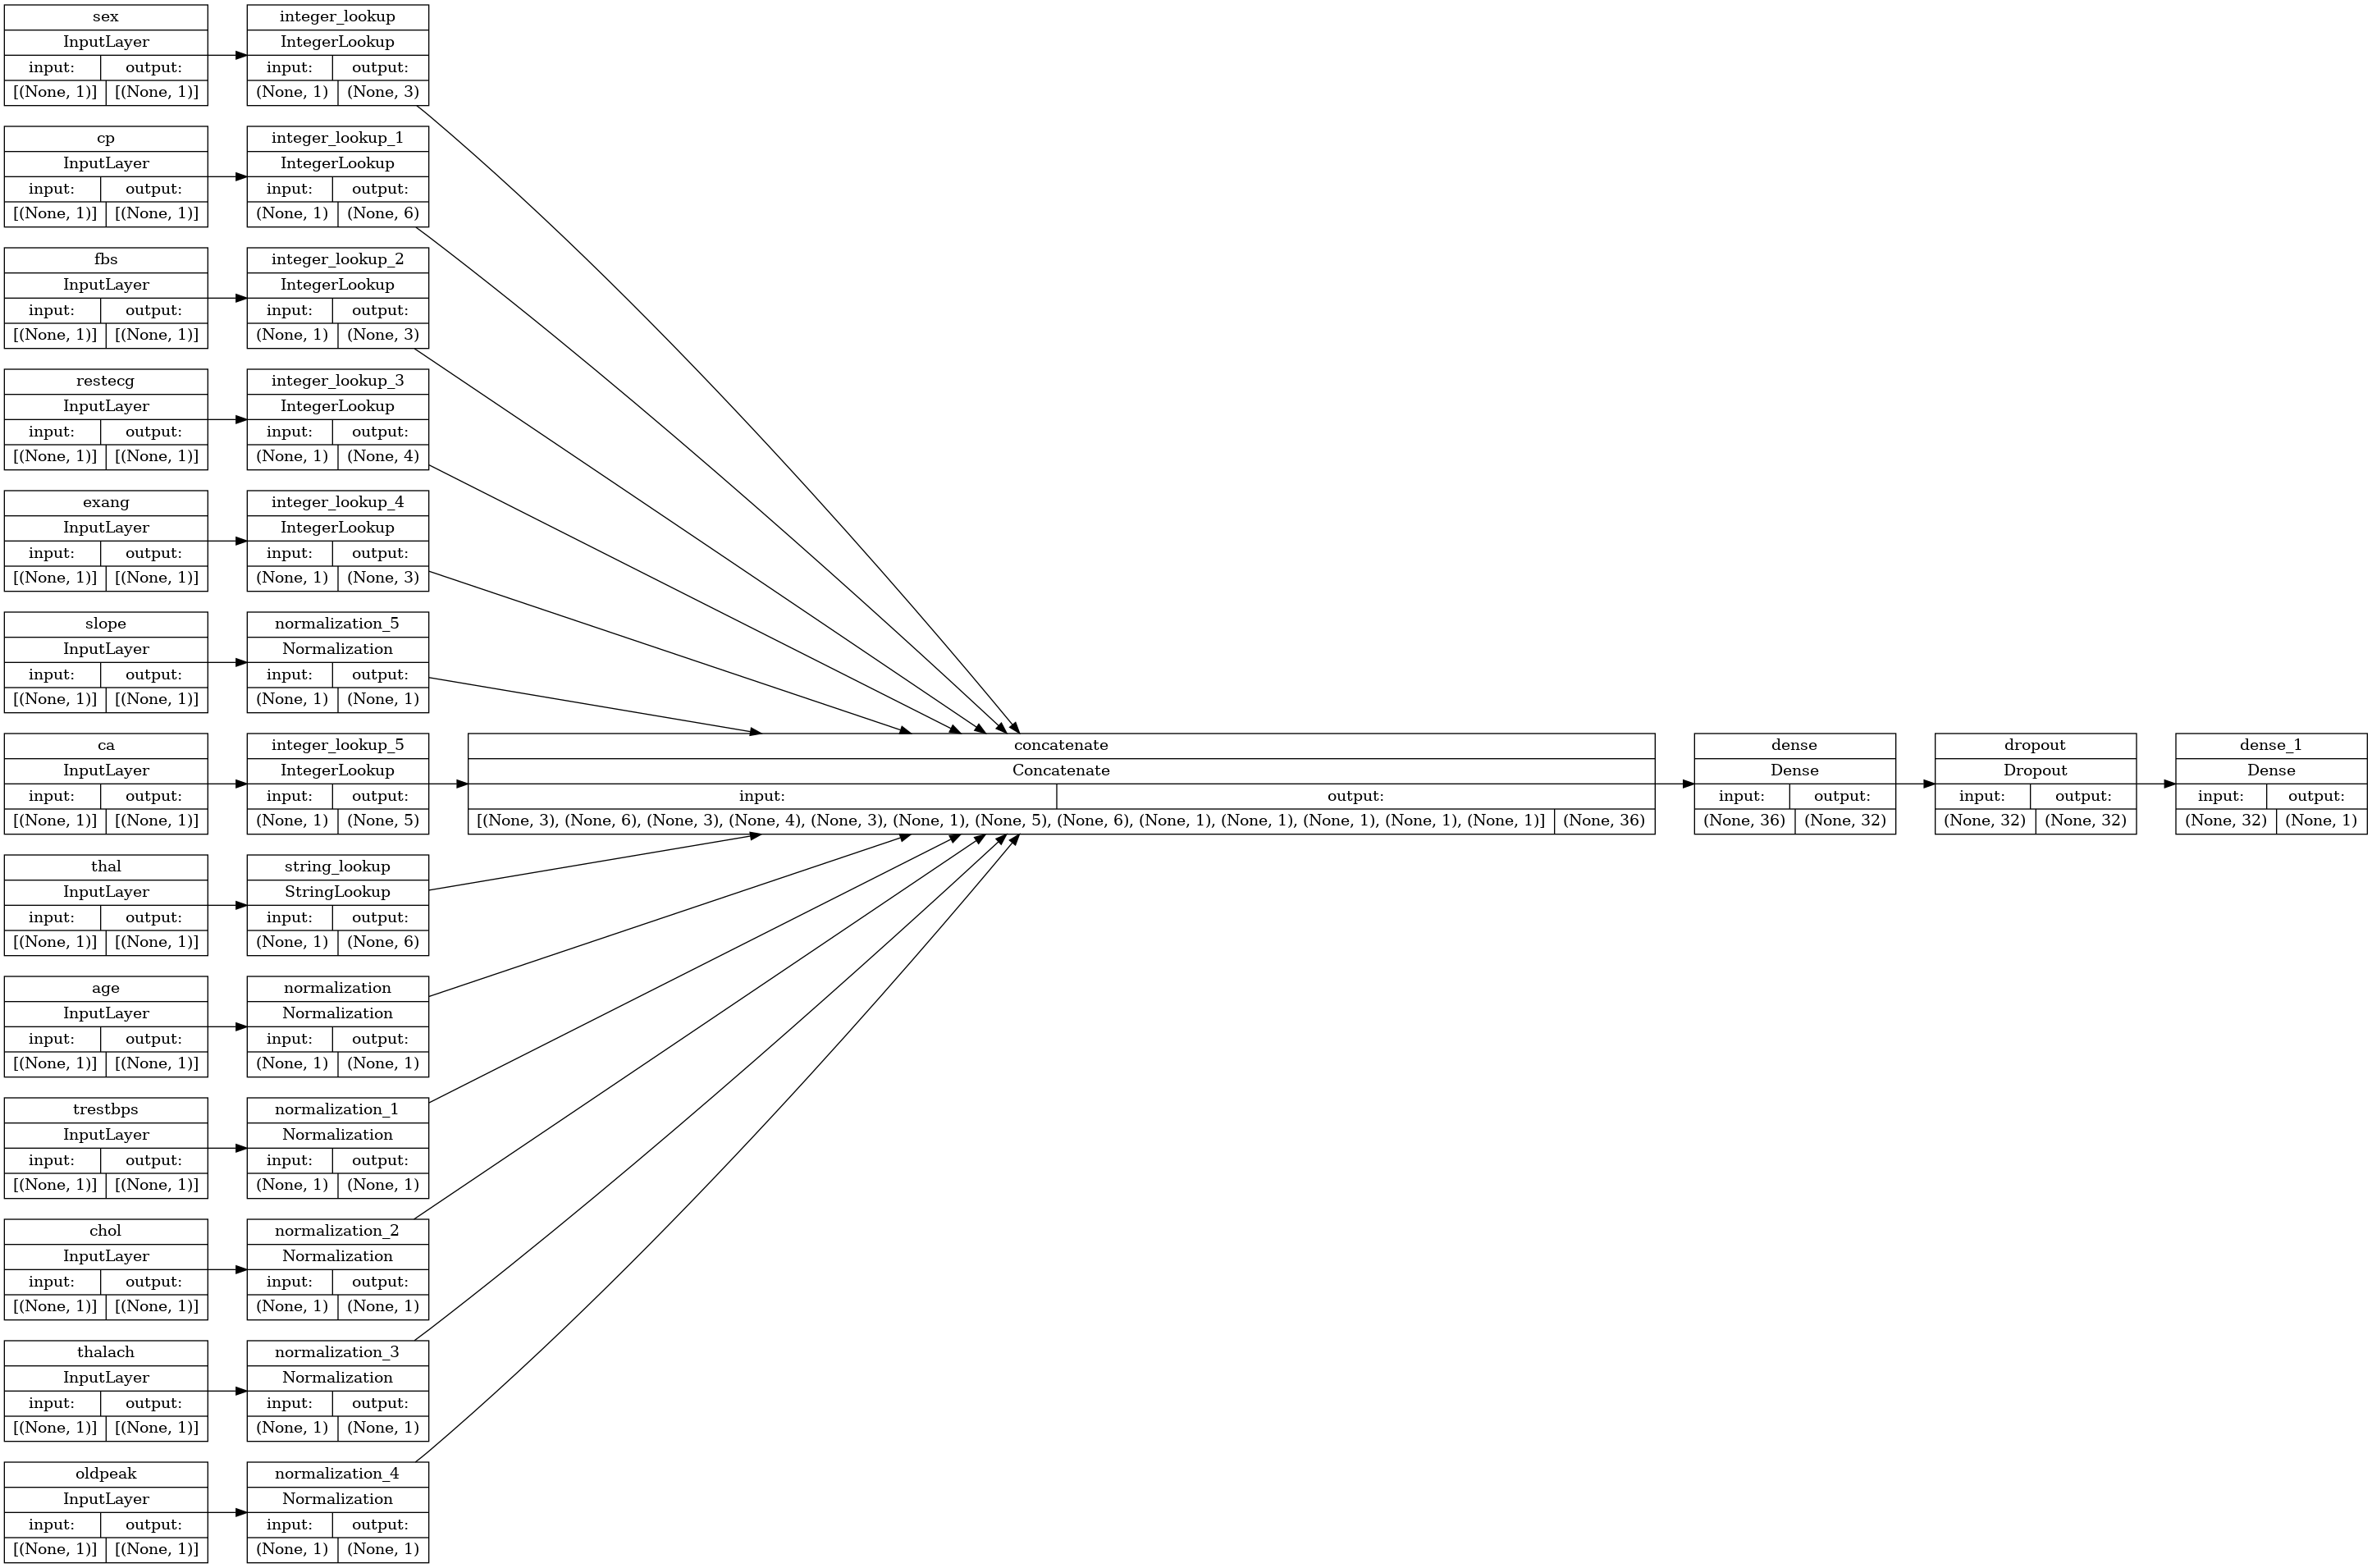

In [12]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [14]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
6/8 [=====================>........] - ETA: 0s - loss: 0.6338 - accuracy: 0.6042

2022-03-20 20:10:10.336782: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 1s 41ms/step - loss: 0.6357 - accuracy: 0.6116 - val_loss: 0.5696 - val_accuracy: 0.7377
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.5786 - accuracy: 0.6983 - val_loss: 0.5328 - val_accuracy: 0.7213
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5573 - accuracy: 0.7273 - val_loss: 0.5057 - val_accuracy: 0.7377
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5467 - accuracy: 0.7314 - val_loss: 0.4845 - val_accuracy: 0.7541
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.5108 - accuracy: 0.7521 - val_loss: 0.4680 - val_accuracy: 0.7705
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.4860 - accuracy: 0.8058 - val_loss: 0.4566 - val_accuracy: 0.7869
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.4638 - accuracy: 0.7893 - val_loss: 0.4445 - val_accuracy: 0.7869
Epoch 8/50
8/8 [======================

In [15]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

In [16]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(f'The heart disease prob is {predictions[0][0] * 100}')

The heart disease prob is 22.926820814609528
